In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

**Transformer는 input sentence를 넣어 output sentence를 생성해내는 model이다. input과 동일한 sentence를 만들어낼 수도, input의 역방향 sentence를 만들어낼 수도, 같은 의미의 다른 언어로 된 sentence를 만들어낼 수도 있다. 이는 model의 train 과정에서 정해지는 것으로, label을 어떤 sentence로 정할 것인가에 따라 달라진다. 결국 Transformer는 sentence 형태의 input을 사용해 sentence 형태의 output을 만들어내는 함수로 이해할 수 있다.**

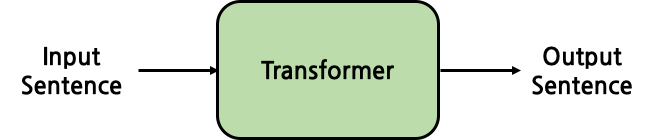




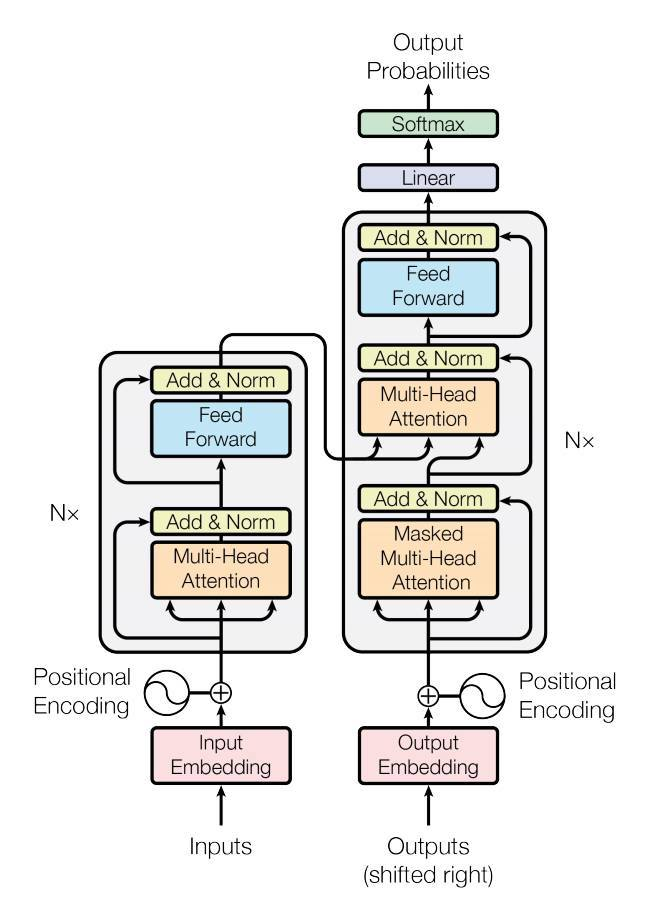

***Transformer의 아키텍쳐는 위와 같으며 왼쪽의 상자를 Encoder, 오른쪽의 상자를 Decoder로 정의한다.***


**Encoder는 sentence를 input으로 받아 하나의 vector를 생성해는 함수이다. 이러한 과정을 Encoding이라고 한다. Encoding으로 생성된 vector는 context라고 부르는데, 말그대로 문장의 ‘문맥’을 함축해 담은 vector이다. Encoder는 이러한 context를 제대로 생성(문장의 정보들을 빠뜨리지 않고 압축)해내는 것을 목표로 학습된다.**

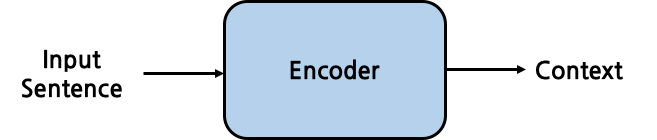

          c=Encoder(x)
          x : sentence
          c : context

**Decoder는 Encoder와 방향이 반대이다. context를 input으로 받아 sentence를 output으로 생성해낸다. 이러한 과정을 Decoding이라고 한다. 사실 Decoder는 input으로 context만을 받지는 않고, output으로 생성해내는 sentence를 right shift한 sentence도 함께 입력받지만, 자세한 것은 당장 이해할 필요 없이 단순히 어떤 sentence도 함께 input으로 받는 다는 개념만 잡고 넘어가자. 정리하자면, Decoder는 sentence, context를 input으로 받아 sentence를 만들어내는 함수이다.**

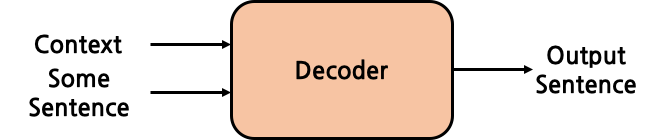

In [ ]:
class Transformer(nn.Module):

  def __init__(self, encoder, decoder):
    super(Transformer, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
  '''
  __init__ 는 Transformer 클래스의 생성자이며 클래스의 인스턴스가 생성될 때 실행됩니다. super(Transformer, self).__init__() 라인은 Transformer 객체를 초기화하기 위해 부모 클래스(nn.Module)의 생성자를 호출합니다.

  여기서 말하는 '초기화'는 개체의 초기 상태를 설정하고 사용할 수 있도록 준비하려면 개체 지향 프로그래밍에서 초기화가 필요

  아래는 그 이유!:

  초기값 설정: 초기화 과정에서 개체의 인스턴스 변수나 속성에 기본값을 지정할 수 있습니다. 이렇게 하면 개체가 의미 있는 초기 값으로 시작하고 원하는 방식으로 사용할 준비가 됩니다.
  메모리 할당: 객체가 생성되면 객체의 데이터와 메서드를 저장하기 위해 메모리를 할당해야 합니다. 초기화는 개체에 필요한 메모리 공간을 예약하여 데이터를 효율적으로 저장하고 조작할 수 있도록 도와줍니다.
  연결 설정: 초기화에는 다른 개체나 리소스에 대한 연결 또는 참조 설정이 포함될 수 있습니다. 예를 들어 Transformer 클래스의 경우 초기화 시 인코더 및 디코더 구성 요소가 매개 변수로 전달됩니다. 이를 통해 Transformer 개체는 인코더 및 디코더 구성 요소를 기능의 일부로 참조하고 활용할 수 있습니다.
  종속성 준비: 초기화는 개체에 필요한 종속성 또는 구성을 설정하는 데 사용할 수 있습니다. 개체를 사용하기 전에 필요한 모든 구성 요소 또는 리소스를 사용할 수 있고 적절하게 구성했는지 확인합니다.

  전반적으로 초기화는 초기 상태를 설정하고, 메모리를 할당하고, 연결을 설정하고, 종속성이 충족되도록 하여 사용할 개체를 준비하는 데 중요한 역할을 합니다. 의도한 작업을 효과적으로 수행할 준비가 된 개체를 만드는 데 도움이 됩니다.
  '''




  def encode(self, src, src_mask):
    out = self.encoder(src, src_mask)
    return out


  def decode(self, z, c):
    out = self.decode(z, c)
    return out


  def forward(self, x, z):
    c = self.encode(x)
    y = self.decode(z, c)
    return y

#Encoder
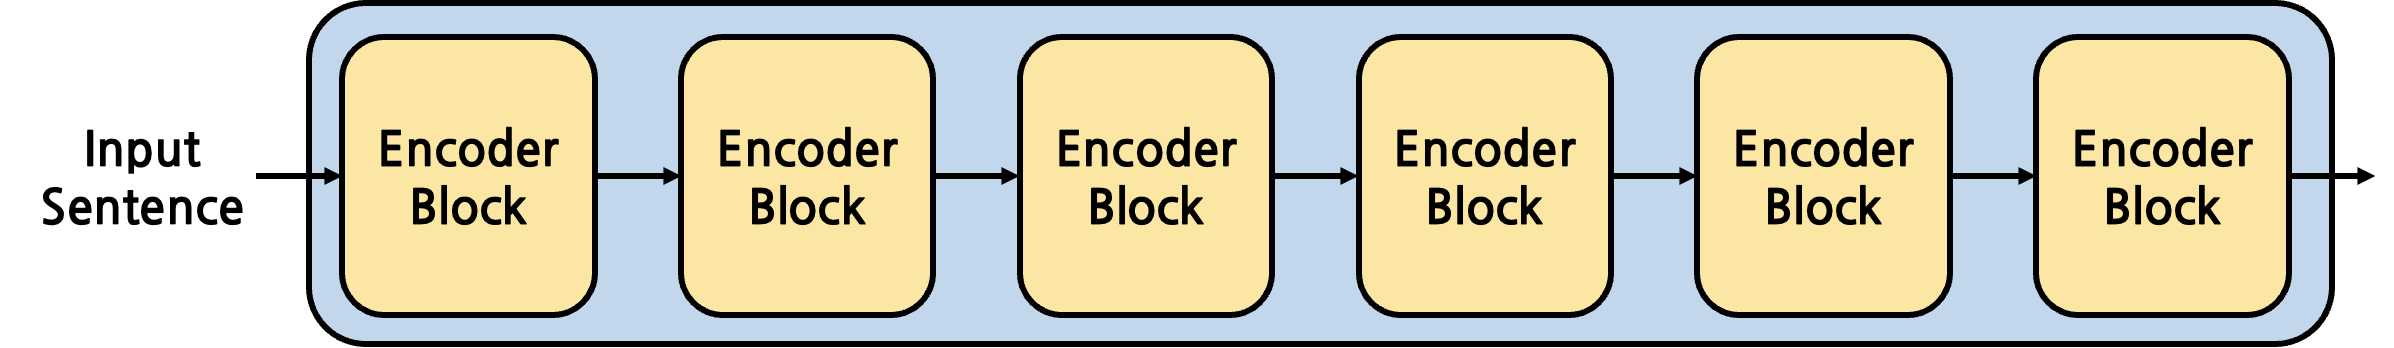

##Encoder는 위와 같은 구조로 이루어져 있다. Encoder Block이 N개 쌓여진 형태이다. 논문에서는 N=6을 사용했다. Encoder Block은 input과 output의 형태가 동일하다. 어떤 matrix를 input으로 받는다고 했을 때, Encoder Block이 도출해내는 output은 input과 완전히 동일한 shape를 갖는 matrix가 된다. 즉, Encoder Block은 shape에 대해 멱등(Idempotent)하다.

##!!여기서 말하는 멱등이란 어떤 함수나 작업을 반복해도 그결과가 한번 했을 때와 동일하게 나온다는 것을 의미함

##Encoder Block N개가 쌓여 Encoder를 이룬다고 했을 때, 첫번째 Encoder Block의 input은 전체 Encoder의 input으로 들어오는 문장 embdding이 된다. 첫번째 block이 output을 생성해내면 이를 두번째 block이 input으로 사용하고, 또 그 output을 세번째 block이 사용하는 식으로 연결되며, 가장 마지막 N번째 block의 output이 전체 Encoder의 output, 즉, context가 된다. 이러한 방식으로 block들이 연결되기 때문에, Encoder Block의 input과 output의 shape는 필연적으로 반드시 동일해야만 한다. 여기서 주목해야 하는 지점은 위에서 계속 언급했던 context 역시 Encoder의 input sentence와 동일한 shape를 가진다는 것이다. 즉, Encoder Block 뿐만 아니라 Encoder 전체도 shape에 대해 멱등(Idempotent)하다.

##Encoder는 왜 여러 개의 block을 겹쳐 쌓는 것일까? 각 Encoder Block의 역할은 무엇일까? 결론부터 말하자면, 각 Encoder Block은 input으로 들어오는 vector에 대해 더 높은 차원(넓은 관점)에서의 context를 담는다. 높은 차원에서의 context라는 것은 더 추상적인 정보라는 의미이다. Encoder Block은 내부적으로 어떠한 Mechanism을 사용해 context를 담아내는데, Encoder Block이 겹겹이 쌓이다 보니 처음에는 원본 문장에 대한 낮은 수준의 context였겠지만 이후 context에 대한 context, context의 context에 대한 context … 와 같은 식으로 점차 높은 차원의 context가 저장되게 된다. Encoder Block의 내부적인 작동 방식은 곧 살펴볼 것이기에, 여기서는 직관적으로 Encoder Block의 역할, Encoder 내부의 전체적인 구조만 이해하고 넘어가자.

##지금까지의 개념을 바탕으로 Encoder를 간단하게 code로 작성해보자.

In [ ]:
class Encoder(nn.Module):
  def __init__(self, encoder_block, n_layer): # n_layer: Encoder Block의 개수
    super(Encoder, self).__init__()
    self.layers= []
    for i in range(n_layer):
      self.layers.append(copy.deepcopy(encoder_block)) # deepcopy를 사용하여 완전히 동일한 encoder층을 여러개로 복사

 def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out


**forward()를 주목해보자. Encoder Block들을 순서대로 실행하면서, 이전 block의 output을 이후 block의 input으로 넣는다. 첫 block의 input은 Encoder 전체의 input인 x가 된다. 이후 가장 마지막 block의 output, 즉 context를 return한다.**


---



#Encoder Block
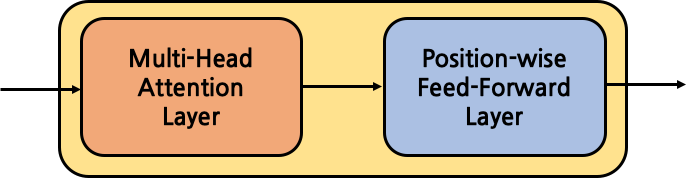


##Encoder Block은 크게 Multi-Head Attention Layer, Position-wise Feed-Forward Layer로 구성된다. 각각의 layer에 대한 자세한 설명은 아래에서 살펴보도록 하고, 우선은 Encoder Block의 큰 구조만을 사용해 간단하게 구현해보자.

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, self_attention, position_ff):
        super(EncoderBlock, self).__init__()
        self.self_attention = self_attention
        self.position_ff = position_ff


    def forward(self, x):
        out = x
        out = self.self_attention(out)
        out = self.position_ff(out)
        return out

#What is Attention?
**Multi-Head Attention은 Scaled Dot-Proudct-Attention을 병렬적으로 여러 개 수행하는 layer이다. 때문에 Multi-Head Attention을 이해하기 위해서는 Scaled Dot-Product Attention에 대해 먼저 알아야만 한다. Attention이라는 것은 넓은 범위의 전체 data에서 특정한 부분에 집중한다는 의미이다. Scaled Dot-Product Attention 자체를 줄여서 Attention으로 부르기도 한다. 다음의 문장을 통해 Attention의 개념을 이해해보자.**

>The animal didn’t cross the street, because it was too tired.

**위 문장에서 ‘it’은 무엇을 지칭하는 것일까? 사람이라면 직관적으로 ‘animal’과 연결지을 수 있지만, 컴퓨터는 ‘it’이 ‘animal’을 가리키는지, ‘street’를 가리키는지 알지 못한다. Attention은 이러한 문제를 해결하기 위해 두 token 사이의 연관 정도를 계산해내는 방법론이다. 위의 경우에는 같은 문장 내의 두 token 사이의 Attention을 계산하는 것이므로, Self-Attention이라고 부른다. 반면, 서로 다른 두 문장에 각각 존재하는 두 token 사이의 Attention을 계산하는 것을 Cross-Attention이라고 부른다.**


#RNN vs Self-Attention
**Transformer에서 벗어나, 이전 RNN의 개념을 다시 생각해보자. RNN은 이전 시점까지 나온 token들에 대한 hidden state 내부에 이전 정보들을 저장했다. RNN의 경우 hidden state를 활용해 이번에 등장한 ‘it’이 이전의 ‘The Animal’을 가리킨다는 것을 알아낼 것이다. Self-Attention 역시 동일한 효과를 내는 것을 목적으로 하나, Recurrent Network에 비해 크게 아래와 같은 2가지 장점을 갖는다.**



1.   Recurrent Network는 i
시점의 hidden state hi
를 구하기 위해서는 hi−1
가 필요했다. 결국, 앞에서부터 순차 계산을 해나가 h0,h1,...,hn
을 구하는 방법밖에 없었기에 병렬 처리가 불가능했다. 하지만 Self-Attention은 모든 token 쌍 사이의 attention을 한 번의 행렬 곱으로 구해내기 때문에 손쉽게 병렬 처리가 가능하다.
2.   Recurrent Network는 시간이 진행될수록 오래된 시점의 token에 대한 정보가 점차 희미해져간다. 위 문장의 예시에서 현재 ‘didn’t’의 시점에서 hidden state를 구한다고 했을 때, 바로 직전의 token인 ‘animal’에 대한 정보는 뚜렷하게 남아있다. 하지만 점차 앞으로 나아갈수록, ‘because’나 ‘it’의 시점에서는 ‘didn’t’ 시점보다는 ‘animal’에 대한 정보가 희미하게 남게 된다. 결국, 서로 거리가 먼 token 사이의 관계에 대한 정보가 제대로 반영되지 못하는 것이다. 반면, Self-Attention은 문장에 token이 n
개 있다고 가정할 경우, n×n
 번 연산을 수행해 모든 token들 사이의 관계를 직접 구해낸다. 중간의 다른 token들을 거치지 않고 바로 direct한 관계를 구하는 것이기 때문에 Recurrent Network에 비해 더 명확하게 관계를 잡아낼 수 있다.



#Query, Key, Value
**지금까지는 추상적으로 Attention에 대한 개념 및 장단점을 살펴봤다. 이제 구체적으로 어떤 방식으로 행렬 곱셈을 사용해 Attention이 수행되는지 알아보자. 우선은 문제를 단순화하기 위해 Cross-Attention이 아닌 Self-Attention의 경우를 보겠다. 위의 예시 문장을 다시 가져와보자.**


>The animal didn’t cross the street, because it was too tired.

**Attention 계산에는 Query, Key, Value라는 3가지 vector가 사용된다. 각 vector의 역할을 정리하면 다음과 같다.**



1.   Query: 현재 시점의 token을 의미
2.   Key: attention을 구하고자 하는 대상 token을 의미
3.  Value: attention을 구하고자 하는 대상 token을 의미 (Key와 동일한 token)


**위 문장에서 ‘it’이 어느 것을 지칭하는지 알아내고자 하는 상황이다. 그렇다면 ‘it’ token과 문장 내 다른 모든 token들에 대해 attention을 구해야 한다. 이 경우에는 Query는 ‘it’으로 고정이다. Key, Value는 서로 완전히 같은 token을 가리키는데, 문장의 시작부터 끝까지 모든 token들 중 하나가 될 것이다. Key와 Value가 ‘The’를 가리킬 경우 ‘it’과 ‘The’ 사이의 attention을 구하는 것이고, Key와 Value가 마지막 ‘tired’를 가리킬 경우 ‘it’과 ‘tired’ 사이의 attention을 구하는 것이 된다. 즉, Key와 Value는 문장의 처음부터 끝까지 탐색한다고 이해하면 된다. Query는 고정되어 하나의 token을 가리키고, Query와 가장 부합하는(Attention이 가장 높은) token을 찾기 위해서 Key, Value를 문장의 처음부터 끝까지 탐색시키는 것이다. 각각의 의미는 이해했으나, Key와 Value가 완전히 같은 token을 가리킨다면 왜 두 개가 따로 존재하는지 의문이 들 수 있다. 이는 이후에 다룰 것이나, 결론부터 말하자면 Key와 Value의 실제 값은 다르지만 의미적으로는 여전히 같은 token을 의미한다. Key와 Value는 이후 Attention 계산 과정에서 별개로 사용하게 된다.**

**Query, Key, Value가 각각 어떤 token을 가리키는지는 이해가 됐을 것이다. 하지만, 그래서 Query, Key, Value라는 세 vector의 구체적인 값은 어떻게 만들어지는지는 우리는 아직 알지 못한다. 정말 간단하게도, input으로 들어오는 token embedding vector를 fully connected layer에 넣어 세 vector를 생성해낸다. 세 vector를 생성해내는 FC layer는 모두 다르기 때문에, 결국 self-attention에서는 Query, Key, Value를 구하기 위해 3개의 서로 다른 FC layer가 존재한다. 이 FC layer들은 모두 같은 input shape, output shape를 갖는다. input shape가 같은 이유는 당연하게도 모두 다 동일한 token embedding vector를 input으로 받기 때문이다. 한편, 세 FC layer의 output shape가 같다는 것을 통해 각각 별개의 FC layer로 구해진 Query, Key, Value가 구체적인 값은 다를지언정 같은 shape를 갖는 vector가 된다는 것을 알 수 있다. 정리하자면, Query, Key, Value의 shape는 모두 동일하다. 앞으로 이 세 vector의 dimension을 dk로 명명한다. 여기서 k는 Key를 의미하는데, 굳이 Query, Key, Value 중 Key를 이름으로 채택한 이유는 특별히 있지 않고, 단지 논문의 notation에서 이를 채택했기 때문이다. 이제 위에서 얘기했던 Key, Value가 다른 값을 갖는 이유를 이해할 수 있다. input은 같은 token embedding vector였을지라도 서로 다른 FC layer를 통해서 각각 Key, Value가 구해지기 때문에 같은 token을 가리키면서 다른 값을 갖는 것이다**

#Scaled Dot-Product Attention
**이제 Query, Key, Value를 활용해 Attention을 계산해보자 Attention이라고 한다면 어떤 것에 대한 Attention인지 불명확하다. 구체적으로, Query에 대한 Attention이다. 이 점을 꼭 인지하고 넘어가자. 이후부터는 Query, Key, Value를 각각 Q
,K,V로 축약해 부른다. Query의 Attention은 다음과 같은 수식으로 계산된다.**

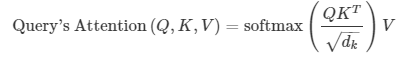

**그림으로 계산의 흐름을 표현하면 다음과 같다.**

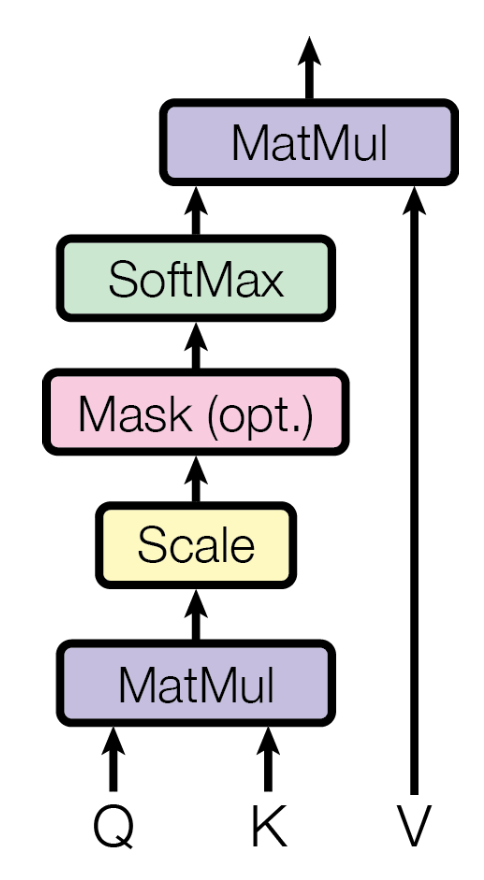

출처: Attention is All You Need [https://arxiv.org/pdf/1706.03762.pdf]



#1:1 Attention

**Q
 는 현재 시점의 token을, K
와 V
는 Attention을 구하고자 하는 대상 token을 의미했다. 우선은 빠른 이해를 돕기 위해 Q
, K
, V
가 모두 구해졌다고 가정한다. 위의 예시 문장을 다시 가져와 ‘it’과 ‘animal’ 사이의 Attention을 구한다고 해보자. dk=3
이라고 한다면, 아래와 같은 모양일 것이다.**

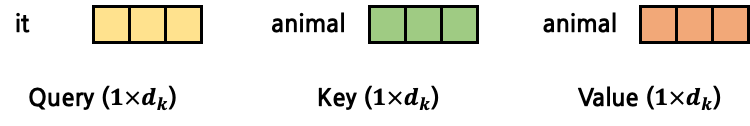

**그렇다면 Q
와 K
를 MatMul(행렬곱)한다는 의미는 어떤 의미일까? 이 둘을 곱한다는 것은 둘의 Attention Score를 구한다는 것이다. Q
와 K
의 shape를 생각해보면, 둘 모두 dk
를 dimension으로 갖는 vector이다. 이 둘을 곱한다고 했을 때(정확히는 K
를 transpose한 뒤 곱함, 즉 두 vector의 내적), 결과값은 어떤 scalar 값이 나오게 될 것이다. 이 값을 Attention Score라고 한다. 이후 scaling을 수행하는데, 값의 크기가 너무 커지지 않도록 dk−−√
로 나눠준다. 값이 너무 클 경우 gradient vanishing이 발생할 수 있기 때문이다. scaling을 제외한 연산 과정은 아래와 같다.**

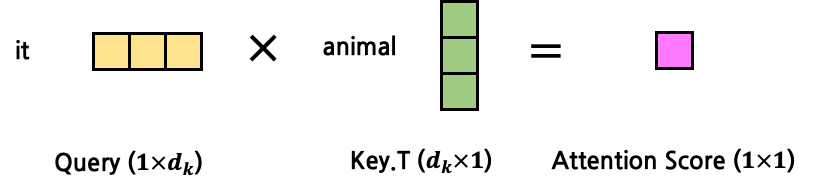

#Self attention은 어떻게 단어간의 상관관계를 파악하는가!

**self attention의 결과로 나오는 score가 어떻게 결정되는지 궁금할 수 있다!!(나도 궁금했으니)  처음에는 기존의 단어가 유사하다면 그 단어를 벡터로 만들었을 때에도 유사성을 가지기 때문에 내적을 하였을 때 보다 높은 상관성을 가졌을 것이라고 생각했다 ..... 하지만 XXXXX**

**결과적으로 말하자면 Transformer의 학습과정을 통해 단어간의 상관관계를 더욱 잘 파악하는 모델을 만드는 것이다.**

**예를 들어 훈련 중에 임베딩 레이어는 유사한 단어나 토큰을 유사한 임베딩에 매핑하도록 학습됩니다. 훈련 중에 비슷한 문맥에서 발생하는 단어의 임베딩은 함께 업데이트되는 반면, 다른 문맥에서 발생하는 단어의 임베딩은 개별적으로 업데이트됩니다. 따라서 학습된 임베딩은 훈련 데이터 내 단어 간의 의미적 및 문맥적 관계를 포착합니다.**

#1:n Attention

**지금까지는 1:1
 Attention을 구했다면, 이를 확장시켜 1:N
 Attention을 구해보자. 그 전에 Q
, K
, V
에 대한 개념을 다시 되짚어보자. Q
는 고정된 token을 가리키고, Q
가 가리키는 token과 가장 높은 Attention을 갖는 token을 찾기 위해 K
, V
를 문장의 첫 token부터 마지막 token까지 탐색시키게 된다. 즉, Attention을 구하는 연산이 Q
 1개에 대해서 수행된다고 가정했을 때, K
, V
는 문장의 길이 n
만큼 반복되게 된다. Q
 vector 1개에 대해서 Attention을 계산한다고 했을 때, K
와 V
는 각각 n
개의 vector가 되는 것이다. 이 때 Q
, K
, V
 vector의 dimension은 모두 dk
로 동일할 것이다. 위의 예시 문장을 다시 갖고 와 ‘it’에 대한 Attention을 구하고자 할 때에는 Q
는 ‘it’, K
, V
는 문장 전체이다. K
와 V
를 각각 n
개의 vector가 아닌 1개의 matrix로 표현한다고 하면 vector들을 concatenate해 n×dk
의 matrix로 변환하면 된다. 그 결과 아래와 같은 shape가 된다.**

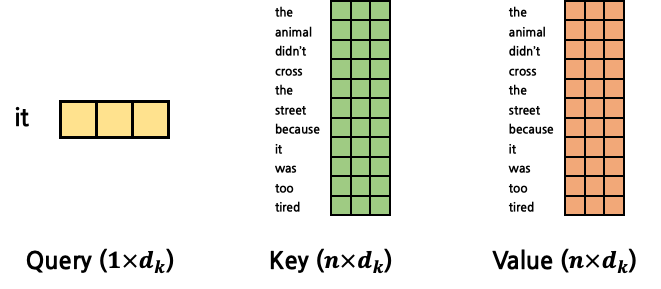

**그렇다면 이들의 Attention Score는 아래와 같이 계산될 것이다.**

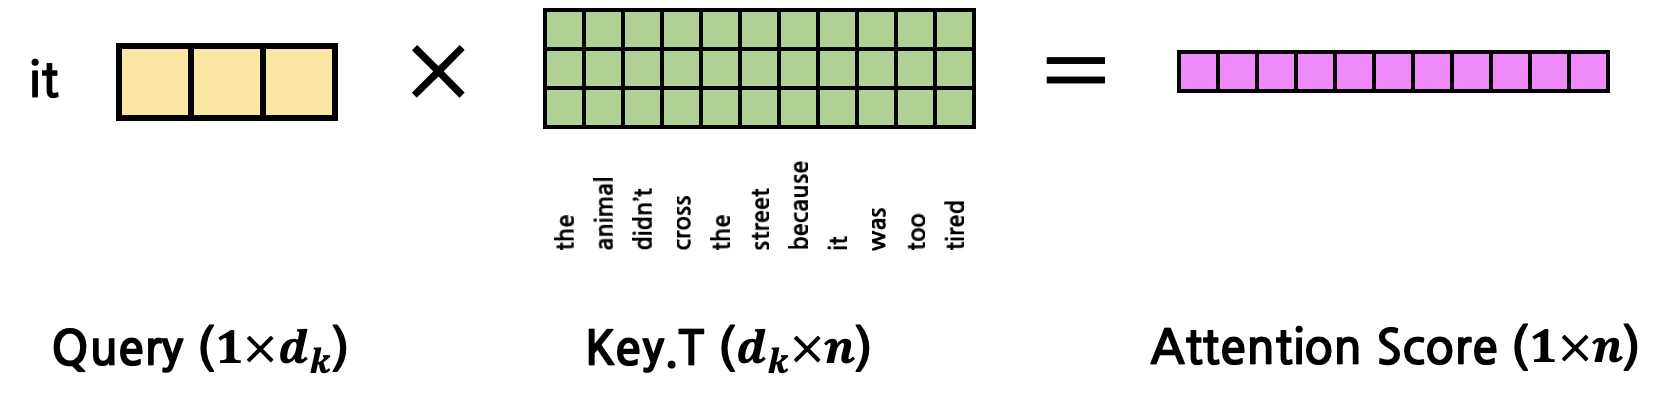

**그 결과 Attention Score는 1×n 의 matrix가 되는데, 이는 Q
의 token과 문장 내 모든 token들 사이의 Attention Score를 각각 계산한 뒤 concatenate한 것과 동일하다. 이를 행렬곱 1회로 수행한 것이다.**

**이렇게 구한 Attention Score는 softmax를 사용해 확률값으로 변환하게 된다. 그 결과 각 Attention Score는 모두 더하면 1인 확률값이 된다. 이 값들의 의미는 Q의 token과 해당 token이 얼마나 Attention을 갖는지(얼마나 연관성이 짙은지)에 대한 비율(확률값)이 된다. 임의로 Attention Probability라고 부른다(논문에서 사용하는 표현은 아니고, 이해를 돕기 위해 임의로 붙인 명칭이다). 이후 Attention Probability를 최종적으로 V
와 곱하게 되는데, V(Attention을 구하고자 하는 대상 token, 다시 한 번 강조하지만 K와 V는 같은 token을 의미한다.)를 각각 Attention Probability만큼만 반영하겠다는 의미이다. 연산은 다음과 같이 이루어진다.**

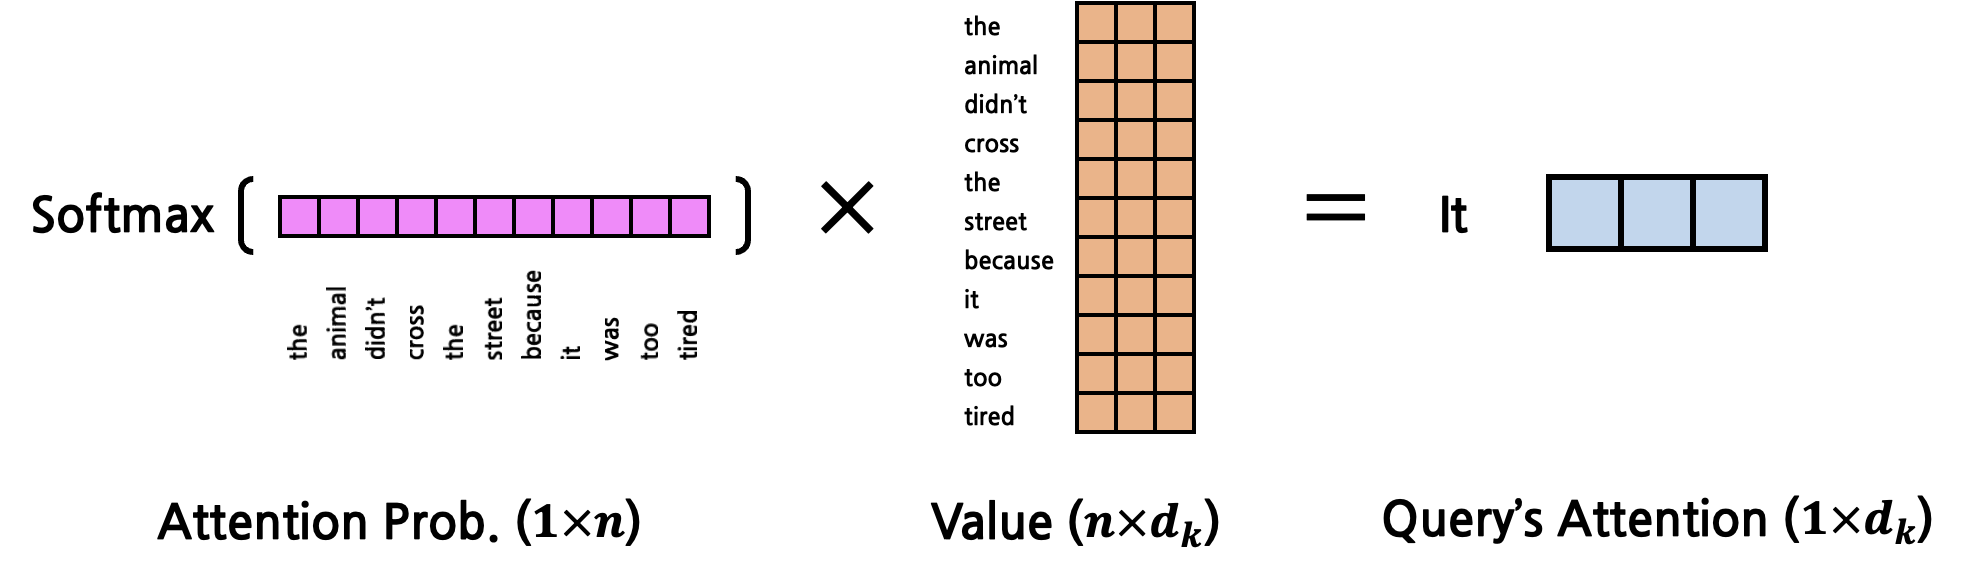

**이렇게 구해진 최종 result는 기존의 Q, K, V와 같은 dimension(dk)를 갖는 vector 1개임을 주목하자. 즉, input으로 Q vector 1개를 받았는데, 연산의 최종 output이 input과 같은 shape를 갖는 것이다. 따라서 Self-Attention 연산 역시 shape에 멱등(Idempotent)하다. (Attention을 함수라고 했을 때 syntax 측면에서 엄밀히 따지자면 input은 Q , K , V총 3개이다. 하지만 개념 상으로는 Q 에 대한 Attention을 의미하는 것이므로 semantic 측면에서 input은 Q 라고 볼 수 있다)**

**최종 결과 벡터에 대해서 이해가 되지 않는 다면 it이라는 token에 대해서 전체 문장과의 상관관계를 구했고 그 결과 it라는 token이 context가 되며 전체 문장토큰과 it이라는 토큰과의 상관관계가 함축 되어 있는 벡터라고 생각하면 좋겠다. 비록 그 형태가 인풋의 it과 같은 형태일지라도!**

#실제 Attention
**지금까지의 Attention 연산은 ‘it’이라는 한 token에 대한 Attention을 구한 것이다. 그러나 우리는 문장 내에서 ‘it’에 대한 Attention만 구하고자 하는 것이 아니다. 모든 token에 대한 Attention을 구해내야만 한다. 따라서 Query 역시 1개의 vector가 아닌 모든 token에 대한 matrix로 확장시켜야 한다.**

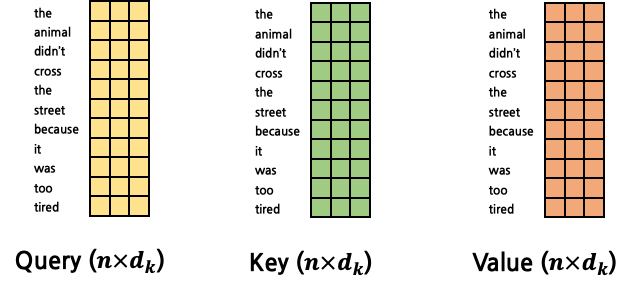

**그렇다면 Attention을 구하는 연산은 아래와 같이 진행된다.**

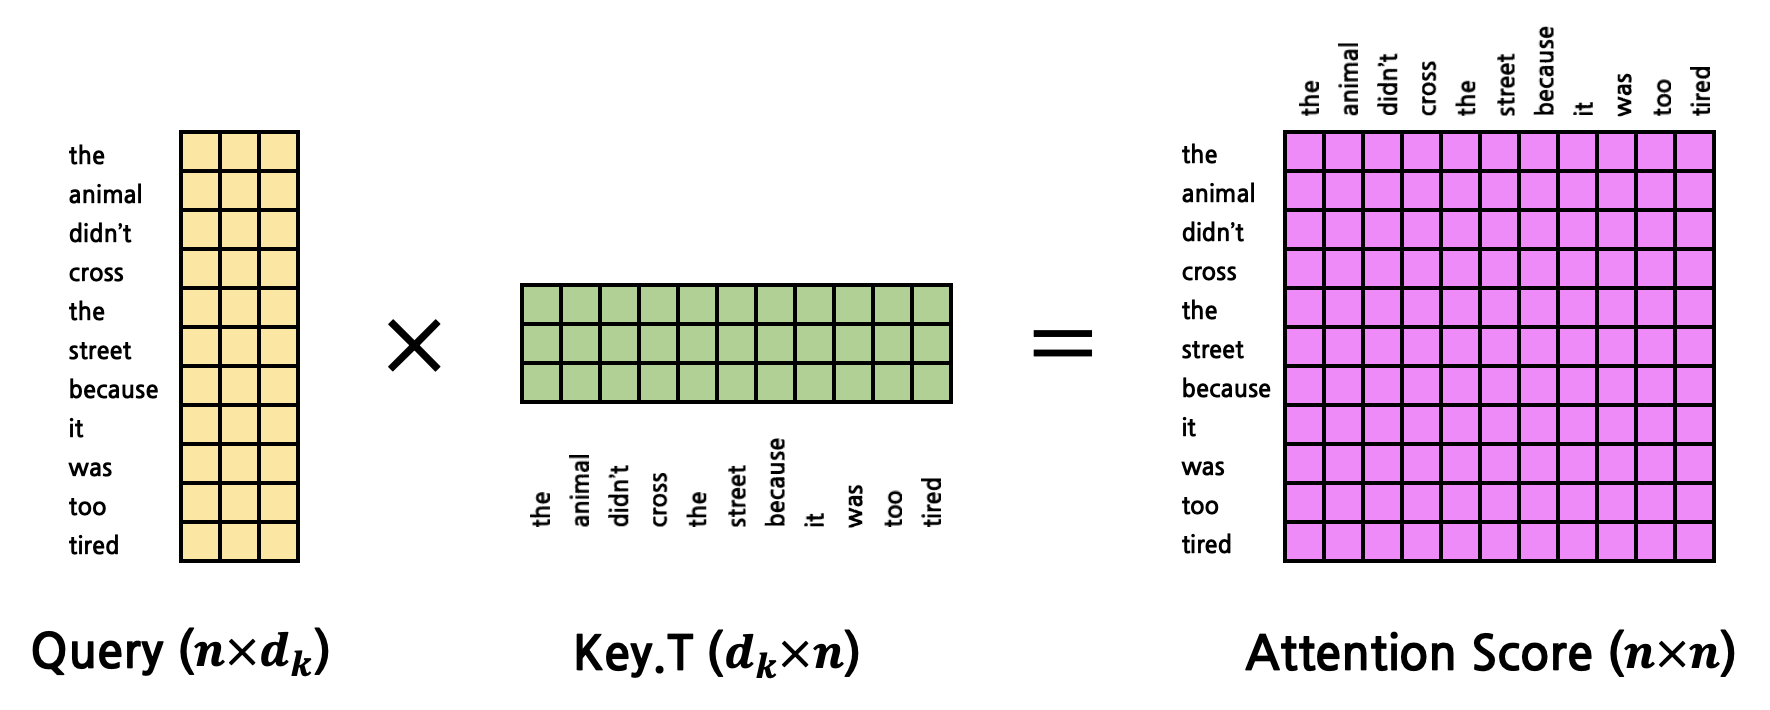

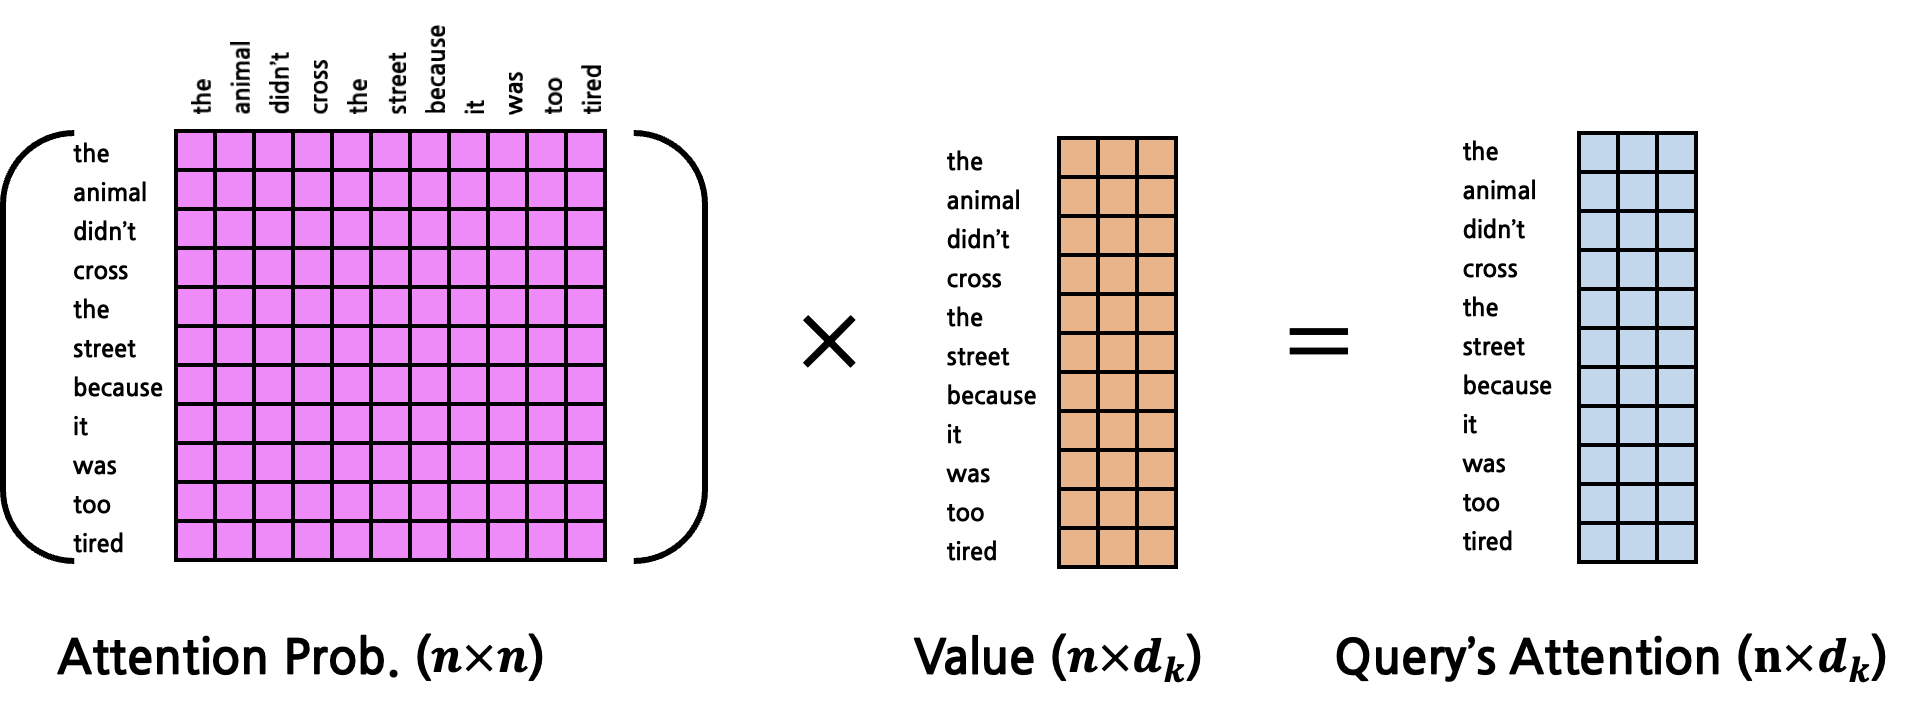

**이제 여기까지 왔으면 Q, K, V 가 주어졌을 때에 어떻게 Attention이 계산되는지 이해했을 것이다. 계속 반복되는 이야기이지만, Self-Attention에서 input(Q )의 shape에 대해 멱등(Idempotent)하다.**

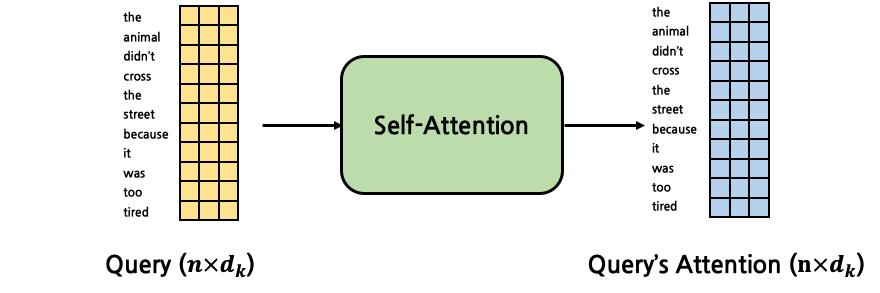

**Q, K, V를 구하는 FC layer에 대해 자세히 살펴보자. Self-Attention 개념 이전에 설명했듯이, 각각 서로 다른 FC layer에 의해 구해진다. FC layer의 input은 word embedding vector들이고, output은 각각 Q, K, V이다. word embedding의 dimension이 dembed라고 한다면, input의 shape는 n×dembed
이고, output의 shape는 n×dk이다. 각각의 FC layer는 서로 다른 weight matrix (dembed×dk)를 갖고 있기 때문에 output의 shape는 모두 동일할지라도, Q, K, V의 실제 값들은 모두 다르다.**
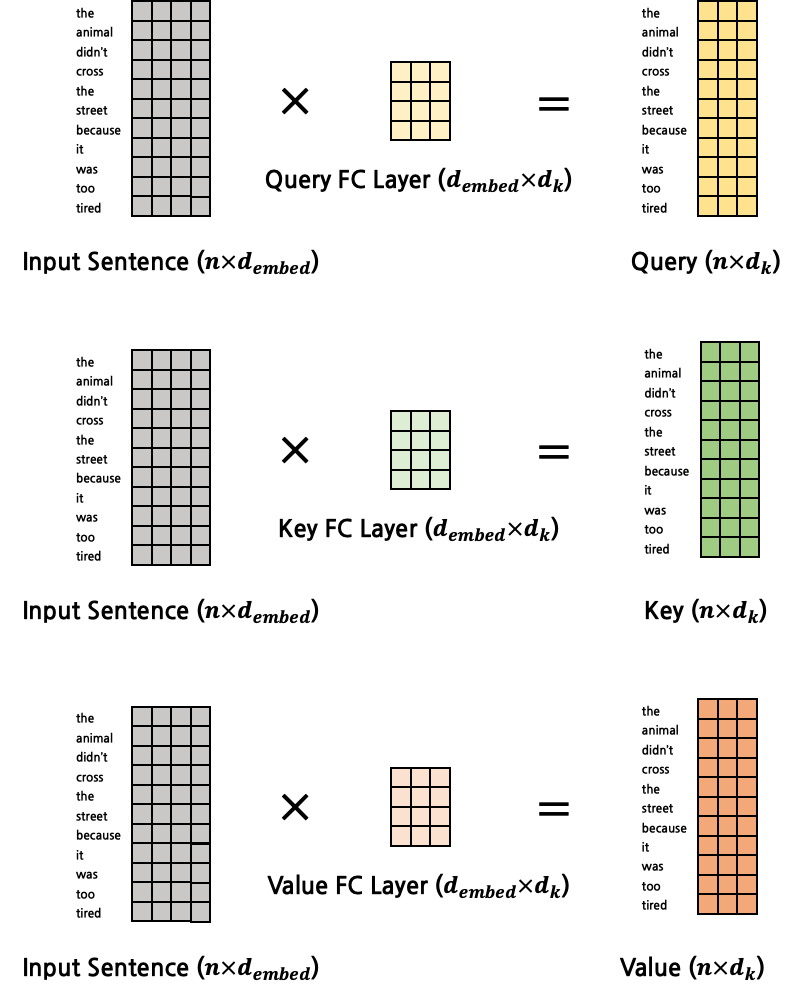

# 왜 Q,K,V에 대해 서로 다른 FC Layer를 적용하는 것일까?

**Self-attention에서는 Query, Key, Value를 선형 변환하여 새로운 표현을 얻습니다. 각각의 FC layer는 서로 다른 가중치를 가지고 있으므로, 입력에 대한 선형 변환이 서로 다른 방식으로 수행됩니다. 이렇게 함으로써 모델은 입력의 다른 측면을 다른 관점에서 파악할 수 있게 된다.**

**만약 Query, Key, Value에 대해 동일한 FC layer 가중치를 사용한다면, 모든 연산이 동일한 선형 변환으로 이루어지므로 입력 간의 구조적인 차이나 관계를 제대로 반영하기 어려울 수 있습니다. 하지만 서로 다른 가중치를 사용함으로써, 모델은 입력의 다양한 측면과 관계를 캡처하고 상호작용할 수 있습니다.**

# Pad Masking
**지금까지 다룬 Self-Attention에서 생략한 과정이 하나 있는데, 바로 masking이다. 사실 논문의 figure에 따르면 Self-Attention에는 masking 과정이 포함되어 있었다.**

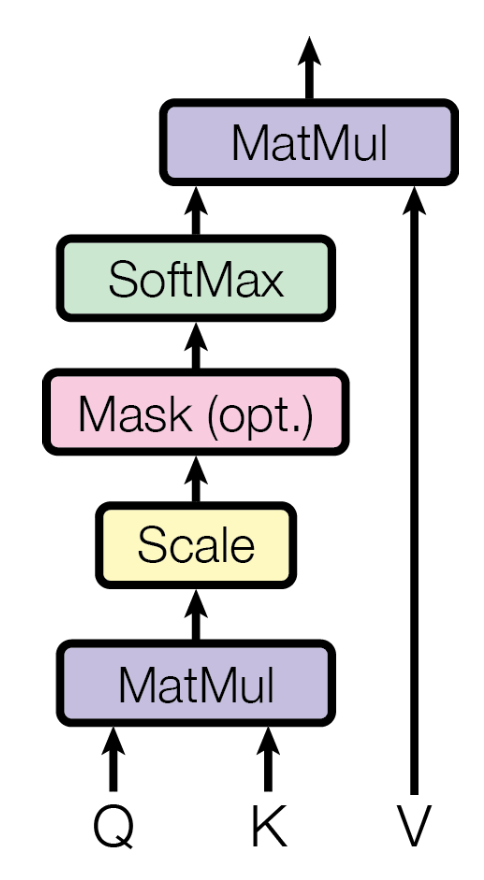

출처: Attention is All You Need [https://arxiv.org/pdf/1706.03762.pdf]

pad는 무엇을 의미하는 것일까? 예시 문장을 다시 가져와보자.

>The animal didn’t cross the street, because it was too tired.

**문장을 word 단위로 tokenize(단순히 python의 split()을 사용)한다면 token의 개수는 총 11개이다. 만약의 각 token의 embedding dimension이 dembed 라고 한다면, 문장 전체의 embedding matrix는 (11×dembed )일 것이다. 그런데 문장의 길이가 더 길거나 짧다면 그 때마다 input의 shape는 바뀌게 된다. 실제 model 학습 과정에서는 한 문장 씩이 아닌 mini-batch씩 여러 문장와야 하는데 각 문장 마다의 length가 다를 경우 batch를 만들어낼 수 없다. 이러한 문제를 해결하기 위해 seq_len (해당 mini-batch 내 token 개수의 최대 값)을 지정하게 되는데, 만약 seq_len 이 20이라고 한다면 위 문장에서는 9개의 빈 token이 있게 된다. 그런데, 이렇게 생겨난 비어있는 pad token에는 attention이 부여되어서는 안된다. 실제로는 존재하지도 않는 token과 다른 token 사이의 attention을 찾아서 계산하고, 이를 반영하는 것은 직관적으로도 말이 안된다는 것을 알 수 있다. 따라서 이러한 pad token들에 대해 attention이 부여되지 않도록 처리하는 것이 pad masking이다. masking은 (seq_len×seq_len)
 shape의 mask matrix를 곱하는 방식으로 이뤄지는데 mask matrix에서 pad token에 해당하는 row, column의 모든 값은 0이다. 그 외에는 모두 1이다. 이러한 연산은 scaling과 softmax 사이에 수행하게 되는데, 사실은 scaling 이전, 이후 언제 적용하든 차이는 없다. scaling은 단순히 모든 값을 dk
로 일괄 나누는 작업이기 때문이다. 대신 반드시 Q 와 K 의 행렬곱 이후, softmax 이전에 적용되어야 한다. mask matrix와 같은 shape는 Q 와 K 의 행렬곱 연산 이후에나 등장하기 때문이다. 또한 softmax는 등장하는 모든 값들을 반영해 확률값을 계산하게 되는데, 이 때 pad token의 값이 반영되어서는 안되므로 softmax 이전에는 반드시 masking이 수행되어야 한다.**

**주의해야 할 점은 실제 model에 들어오는 input은 한 개의 문장이 아니라 mini-batch이기 때문에 Q
, K
, V
의 shape에 n_batch
가 추가된다. Encoder가 받는 input의 shape는 n_batch×seq_len×dembed
 이었겠으나, 3개의 FC Layer를 거쳐 Q
, K
, V
는 각각 n_batch×seq_len×dk
의 shape를 갖는다. calculate_attention()의 인자로 받는 mask는 아마도 pad mask일텐데, 이 mask를 생성하는 code는 이후에 다뤄본다.**

1.   항목 추가
2.   항목 추가



In [ ]:
def calculate_attention(query,key,value,mask):
    # query, key, value: (n_batch, seq_len, d_k)
    # mask: (n_batch, seq_len, seq_len)
    d_k =key.shape[-1]
    attention_score = torch.matmul(query, key.transpose(-2,-1)) # Q x K^T, (n_batch, seq_len, seq_len) 해당 코드는텐서의 뒤에서 두 번째와 마지막 차원을 교환하여 차원을 변환한 결과를 반환 예를 들어 (3,4,5)차원이라면 (3,5,4)로 변경
    attention_score  = attention_score/math.sqrt(d_k)
    if mask is not None:
      attention_score = attention_score.masked_fill(mask==0,-1e9)
    attention_prob  = F.softmax(attention_score, dim=-1) # (n_batch, seq_len, seq_len)
    out = torch.matmul(attention_prob, value) # (n_batch, seq_len, d_k)
    return out

#Multi-Head Attention Layer
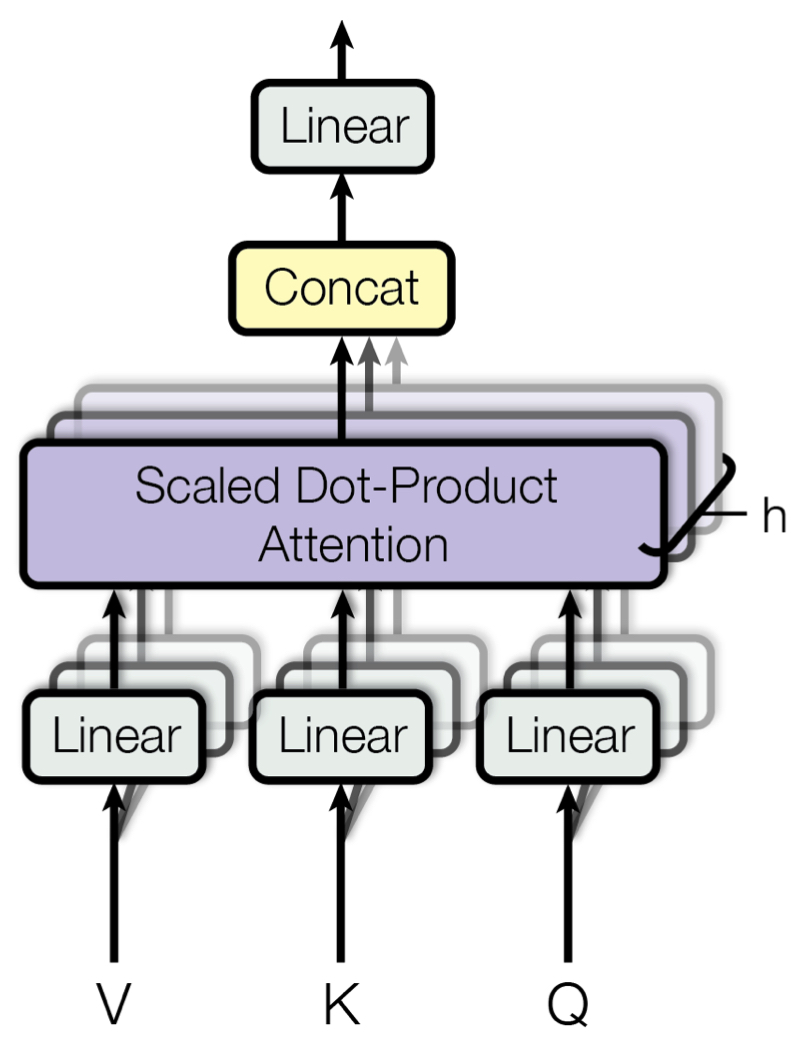

출처: Attention is All You Need [https://arxiv.org/pdf/1706.03762.pdf]



**. Attention 계산을 논문에서는 Scaled Dot-Product Attention이라고 명명한다. Transformer는 Scaled Dot Attention을 한 Encoder Layer마다 1회씩 수행하는 것이 아니라 병렬적으로 h
회 각각 수행한 뒤, 그 결과를 종합해 사용한다. 이 것이 Multi-Head Attention이다. 이러한 연산을 수행하는 이유는 다양한 Attention을 잘 반영하기 위해서이다. 만약 하나의 Attention만 반영한다고 했을 때, 예시 문장에서 ‘it’의 Attention에는 ‘animal’의 것이 대부분을 차지하게 될 것이다. 하지만 여러 종류의 attention을 반영한다고 했을 때 ‘tired’에 집중한 Attention까지 반영된다면, 최종적인 ‘it’의 Attention에는 ‘animal’이라는 지칭 정보, ‘tired’ 이라는 상태 정보까지 모두 담기게 될 것이다. 이 것이 Multi-Head Attention을 사용하는 이유이다.**

**구체적인 연산 방법을 살펴보자. 논문에서는 h=8
을 채택했다. Scaled Dot-Product Attention에서는 Q
, K
, V
를 위해 FC layer가 총 3개 필요했었는데, 이를 h
회 수행한다고 했으므로 3∗h
개의 FC layer가 필요하게 된다. 각각 연산의 최종 output은 n×dk
의 shape인데, 총 h
개의 n×dk
 matrix를 모두 concatenate해서 n×(dk∗h)
의 shape를 갖는 matrix를 만들어낸다. (n
은 token의 개수로, 사실상 seq_len
이다. notation의 단순화를 위해 n
으로 잠시 변경한다.) 이 때 dk∗h
의 값을 dmodel
로 명명한다. dmodel=dk∗h
 수식은 실제 코드 구현에서 매우 중요한 개념이므로 꼭 기억하고 넘어가자. 대개 dmodel
은 Encoder의 input으로 들어오는 shape인 dembed
와 동일한 값을 사용한다. dmodel
과 dembed
의 구분이 어렵다면, 사실상 서로 동일한 값이라고 봐도 무방하다.**

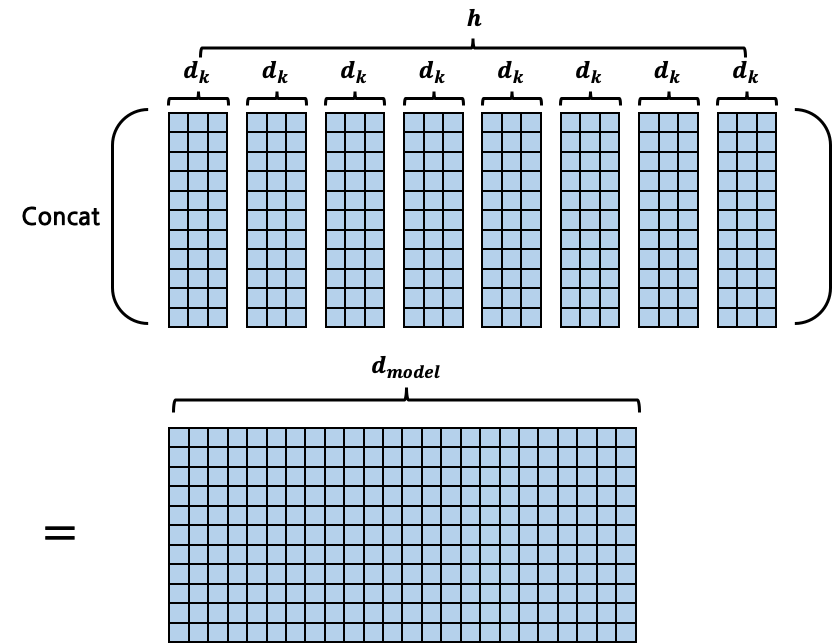

**사실 위의 설명은 개념 상의 이해를 돕기 위한 것이고, 실제 연산은 병렬 처리를 위해 더 효율적인 방식으로 수행된다. 기존의 설명에서 Q
, K
, V
를 구하기 위한 FC layer는 dembed
를 dk
로 변환했다. 이렇게 구해낸 Q
, K
, V
로 각각의 Attention을 계산해 concatenate하는 방식은 별개의 Attention 연산을 총 h
회 수행해야 한다는 점에서 매우 비효율적이다. 따라서 실제로는 Q
, K
, V
 자체를 n×dk
가 아닌, n×dmodel
로 생성해내서 한 번의 Self-Attention 계산으로 n×dmodel
의 output을 만들어내게 된다. 때문에 Q
, K
, V
를 생성해내기 위한 dembed×dk
의 weight matrix를 갖는 FC layer를 3∗h
개 운용할 필요 없이 dembed×dmodel
의 weight matrix를 갖는 FC layer를 3
개만 운용하면 된다.**

###!!!!!!즉 멀티헤드에 필요한 Q,K,V를 위한 FC레이어를 모두 만들 필요없이 결과적으로 필요한 *h 개수만큼의 아웃풋이 차원이 나올수 있는 FC레이어를 만든다는 개념

>여기서 우리가 주목해야 하는 지점은 다양한 Attention을 반영한다는 Multi-Head Attention의 심오한 개념은 실제 구현상으로는 단지 dk
의 크기를 dmodel
로 확장시키는 단순한 변경으로 끝난다는 점이다. 때문에 사람에 따라서는 Multi-Head Attention을 다양한 Attention을 반영한다기 보다는 Q
, K
, V
 vector에는 담을 수 있는 정보의 양이 dk
의 dimension으로는 절대적으로 너무 작기 때문에 더 많은 정보를 담아내기 위해 Q
, K
, V
 vector의 dimension을 늘린 것으로 이해하기도 한다.

**다시 본론으로 되돌아와서 최종적으로 생성해된 matrix (n×dmodel)
를 FC layer에 넣어 multi-head attention의 input과 같은 shape(n×dembed
)의 matrix로 변환하는 과정이 필요하다. 따라서 마지막 FC layer의 input dimension은 dmodel
, output dimension은 dembed
가 된다. 이는 multi-head attention layer도 하나의 함수라고 생각했을 때, input의 shape와 output의 shape가 동일하게 하기 위함이다.**

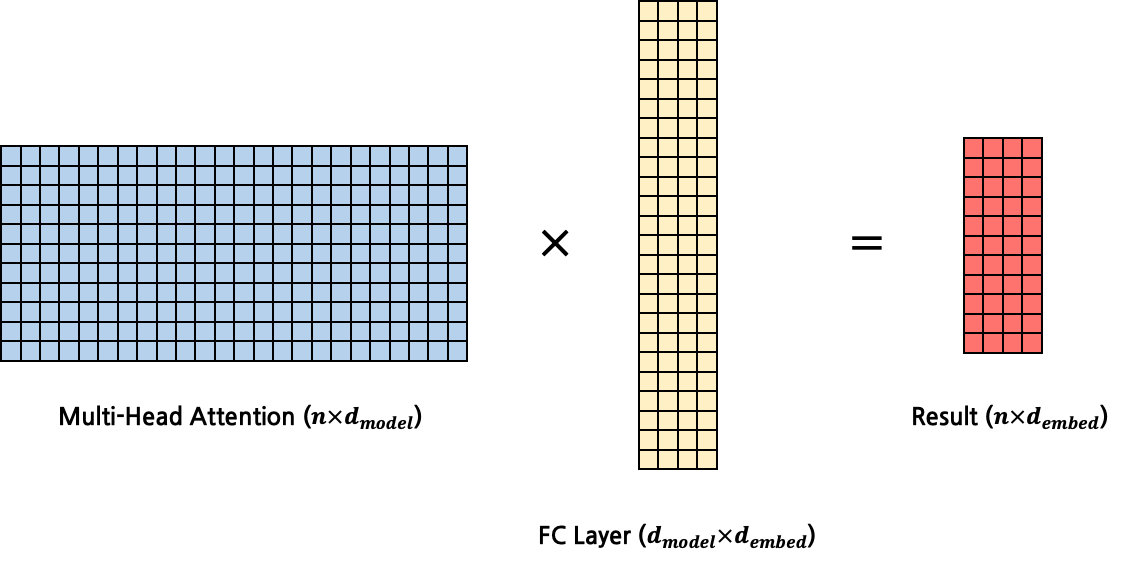

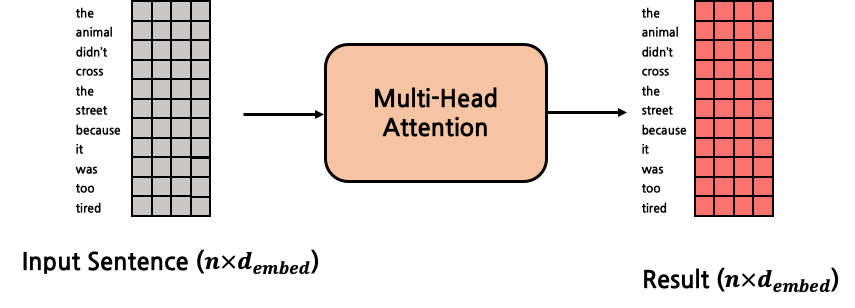

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
  def __init__(self, d_model, h, qkv_fc, out_fc):
    super(MultiHeadAttentionLayer, self).__init()
    self.d_model = d_model
    self.h = h
    self.q_fc= copy.deepcopy(qkv_fc)# (d_embed, d_model)
    self.k_fc= copy.deepcopy(qkv_fc)# (d_embed, d_model)
    self.v_fc= copy.deepcopy(qkv_fc)# (d_embed, d_model)
    self.out_fc =out_fc #(d_model, d_embed)

  def forward(self, *args, query, key, value, mask=None):
    # query, key, value: (n_batch, seq_len, d_embed)
    # mask: (n_batch, seq_len, seq_len)
    # return value: (n_batch, h, seq_len, d_k)

    n_batch =query.size(0)

    def transform(x, fc): # (n_batch, seq_len, d_embed)
      out = fc(x) # (n_batch, seq_len, d_model)
      out = out.view(n_batch, -1, self.h, self.d_model//self.h) # (n_batch, seq_len, h, d_k) 여기서 -1은 나머지의 크기를 자동으로 계산해서 입력 해주는 것
      out = out.transpose(1, 2) # (n_batch, h, seq_len, d_k)
      return out
    query =transform(query, self.q_fc) #(n_batch, h, seq_len, d_k)
    key = transform(key, self.k_fc)     # (n_batch, h, seq_len, d_k)
    value = transform(value, self.v_fc) # (n_batch, h, seq_len, d_k)

    out = self.calculate_attention(query ,key, value, mask)# (n_batch, h, seq_len, d_k)
    out = out.transpose(1, 2) # (n_batch, seq_len, h, d_k)
    out = out.contiguous().view(n_batch, -1, self.d_model) # (n_batch, seq_len, d_model)
    out = self.out_fc(out) # (n_batch, seq_len, d_embed)
    return out


SyntaxError: ignored

**인자로 받은 query, key, value는 실제 Q
, K
, V
 matrix가 아닌, input sentence embedding (n_batch×seq_len×dembed)
 이다. 이를 3개의 FC Layer에 넣어 Q
, K
, V
를 구하는 것이다. Self-Attention이기에 당연히 Q
, K
, V
는 같은 sentence에서 나오게 되는데 왜 별개의 인자로 받는지 의문일 수 있다. 이는 Decoder에서 활용하기 위함이기에, 추후에 이해할 수 있을 것이다. mask는 기본적으로 한 문장에 대해 (seq_len×seq_len
)의 shape를 갖는데, mini-batch이므로 (n_batch×seq_len×seq_len
)의 shape를 갖는다.**

**transform()은 Q
, K
, V
를 구하는 함수이다. 따라서 input shape는 (n_batch×seq_len×dembed
)이고, output shape는 (n_batch×seq_len×dmodel
)이어야 한다. 하지만 실제로는 단순히 FC Layer만 거쳐가는 것이 아닌 추가적인 변형이 일어난다. 우선 dmodel
을 h
와 dk
로 분리하고, 각각을 하나의 dimension으로 분리한다. 따라서 shape는 (n_batch×seq_len×h×dk
)가 된다. 이후 이를 transpose해 (n_batch×h×seq_len×dk
)로 변환한다. 이러한 작업을 수행하는 이유는 위에서 작성했던 calculate_attention()이 input으로 받고자 하는 shape가 (n_batch×...×seq_len×dk
)이기 때문이다. 아래에서 calculate_attention()의 code를 다시 살펴보자. 위에서 작성한 code에서 각 step마다 shape를 설명하는 주석만 변경됐다.**

In [ ]:
def calculate_attention(self, query, key, value, mask):
    # query, key, value: (n_batch, h, seq_len, d_k)
    # mask: (n_batch, 1, seq_len, seq_len)
    d_k = key.shape[-1]
    attention_score = torch.matmul(query, key.transpose(-2, -1)) # Q x K^T, (n_batch, h, seq_len, seq_len)
    attention_score = attention_score / math.sqrt(d_k)
    if mask is not None:
        attention_score = attention_score.masked_fill(mask==0, -1e9)
    attention_prob = F.softmax(attention_score, dim=-1) # (n_batch, h, seq_len, seq_len)
    out = torch.matmul(attention_prob, value) # (n_batch, h, seq_len, d_k)
    return out

**우선 dk
를 중심으로 Q
와 K
 사이 행렬곱 연산을 수행하기 때문에 Q
, K
, V
의 마지막 dimension은 반드시 dk
여야만 한다. 또한 attention_score의 shape는 마지막 두 dimension이 반드시 (seq_len×seq_len
)이어야만 masking이 적용될 수 있기 때문에 Q
, K
, V
의 마지막 직전 dimension(.shape[-2])는 반드시 seq_len
이어야만 한다.**

**다시 forward()로 되돌아와서, calculate_attention()을 사용해 attention을 계산하고 나면 그 shape는 (n_batch×h×seq_len×dk
)이다. Multi-Head Attention Layer 역시 shape에 대해 멱등(Idempotent)해야만 하기 때문에, output shape는 input과 같은 (n_batch×seq_len×dembed
)여야만 한다. 이를 위해 h
와 seq_len
의 순서를 뒤바꾸고(.transpose(1, 2)) 다시 h
와 dk
를 dmodel
로 결합한다. 이후 FC Layer를 거쳐 dmodel
을 dembed
로 변환하게 된다.**

**Encoder Block으로 다시 되돌아가보자. pad mask는 Encoder 외부에서 생성할 것이므로 Encoder Block의 forward()에서 인자로 받는다. 따라서 forward()의 최종 인자는 x, mask가 된다. 한편, 이전에는 Multi-Head Attention Layer의 forward()의 인자가 1개(x)일 것으로 가정하고 code를 작성했는데, 실제로는 query, key, value를 받아야 하므로 이를 수정해준다. 이에 더해 mask 역시 인자로 받게 될 것이다. 따라서 Multi-Head Attention Layer의 forward()의 인자는 최종적으로 x, x, x, mask가 된다.**

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, self_attention, position_ff):
        super(EncoderBlock, self).__init__()
        self.self_attention = self_attention
        self.position_ff = position_ff


    def forward(self, src, src_mask):
        out = src
        out = self.self_attention(query=out, key=out, value=out, mask=src_mask)
        out = self.position_ff(out)
        return out

**mask 인자를 받기 위해 Encoder 역시 수정이 가해진다. forward()의 인자에 mask를 추가하고, 이를 각 sublayer의 forward()에 넘겨준다.**

In [ ]:
class Encoder(nn.Module):

    def __init__(self, encoder_layer, n_layer):  # n_layer: Encoder Layer의 개수
        super(Encoder, self).__init__()
        self.layers = []
        for i in range(n_layer):
            self.layers.append(copy.deepcopy(encoder_layer))


    def forward(self, src, src_mask):
        out = src
        for layer in self.layers:
            out = layer(out, src_mask)
        return out

**Transformer 역시 수정해야 한다. forward()의 인자에 src_mask를 추가하고, encoder의 forward()에 넘겨준다.**

In [ ]:
class Transformer(nn.Module):

    def __init__(self, encoder, decoder):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, src, src_mask):
        out = self.encoder(src, src_mask)
        return out


    def decode(self, z, c):
        out = self.decode(z, c)
        return out


    def forward(self, src, tgt, src_mask):
        encoder_out = self.encode(src, src_mask)
        y = self.decode(tgt, encoder_out)
        return y

**그동안 생략했던 과정인 pad masking을 생성하는 make_pad_mask()이다. 인자로는 query와 key를 받는데, 각각은 n_batch×seq_len
의 shape를 갖는다. embedding을 획득하기도 전, token sequence상태로 들어오는 것이다. 여기서 <pad>의 index를 의미하는 pad_idx(대개 1)와 일치하는 token들은 모두 0, 그 외에는 모두 1인 mask를 생성한다.**

In [ ]:
def make_pad_mask(self, query, key, pad_idx=1):
  # query: (n_batch, query_seq_len)
  # key: (n_batch, key_seq_len)
  query_seq_len, key_seq_len =query.size(1), key.size(1)

  key_mask = key.ne(pad_idx).unsqueeze(1).unsqueeze(2) # (n_batch, 1, 1, key_seq_len) ne함수를 통해 pad에 해당하는 값은 모두 0으로 치환 나머지 값은 1로 치환한 텐서를 반환
  key_mask = key_mask.repeat(1, 1, query_seq_len, 1)    # (n_batch, 1, query_seq_len, key_seq_len) repeat함수를 통해 (1, 1, query_seq_len, 1)쿼리시퀀스 값을 준 차원만 반복해서 확장
  query_mask = query.ne(pad_idx).unsqueeze(1).unsqueeze(3)  # (n_batch, 1, query_seq_len, 1)
  query_mask = query_mask.repeat(1, 1, 1, key_seq_len)  # (n_batch, 1, query_seq_len, key_seq_len)

  mask = key_mask & query_mask
  mask.requires_grad = False
  return mask
  '''
  import torch

# 예시 입력 텐서
key = torch.tensor([[1, 2, 3],
                    [4, 0, 5],
                    [6, 7, 0]])

pad_idx = 0

# key.ne(pad_idx).unsqueeze(1).unsqueeze(2) 연산 적용
result = key.ne(pad_idx).unsqueeze(1).unsqueeze(2)

print(result)

tensor([[[1],
         [1],
         [1]],

        [[1],
         [0],
         [1]],

        [[1],
         [1],
         [0]]], dtype=torch.uint8)
  '''


**지금까지 Encoder에서 다뤘던 pad masking은 모두 동일한 문장 내에서 이뤄지는 Self-Attention이었다. 이러한 Self-Attention의 경우에는 make_pad_mask()의 인자로 들어오는 query와 key가 동일할 것이다. 반면, 서로 다른 문장(예를 들면 source, target) 사이 이뤄지는 Cross-Attention의 경우, query는 source, key는 target과 같이 서로 다른 값이 들어올 수 있다.**

In [ ]:
def make_src_mask(self, src):
    pad_mask = self.make_pad_mask(src, src)
    return pad_mask

#Position-wise Feed Forward Layer
**단순하게 2개의 FC Layer를 갖는 Layer이다. 각 FC Layer는 (dembed×dff
), (dff×dembed
)의 weight matrix를 갖는다. 즉, Feed Forward Layer 역시 shape에 대해 멱등(Idempotent)하다. 다음 Encoder Block에게 shape를 유지한 채 넘겨줘야 하기 때문이다. 정리하자면, Feed Forward Layer는 Multi-Head Attention Layer의 output을 input으로 받아 연산을 수행하고, 다음 Encoder Block에게 output을 넘겨준다. 논문에서의 수식을 참고하면 첫번째 FC Layer의 output에 ReLU()를 적용하게 된다.**

**1.relu와 같은 함수를 추가하여 비선형성을 추가해주며 이를 통해 모델이 보다 복잡한(선형적인 것만이 아닌 비선형적인 것도)데이터를 학습 할수 있게 돕는다.**
**2. 선형변환을 통해 어떠한 기능을 추가하는데 이부분은 선형대수학 선형변환 부분을 조금 더 공부해서 추가!**

In [ ]:
class PositionWiseFeedForwardLayer(nn.Module):

    def __init__(self, fc1, fc2):
        super(PositionWiseFeedForwardLayer, self).__init__()
        self.fc1 = fc1   # (d_embed, d_ff)
        self.relu = nn.ReLU()
        self.fc2 = fc2 # (d_ff, d_embed)


    def forward(self, x):
        out = x
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

**생성자의 인자로 받는 두 FC Layer는 (dembed×dff
), (dff×dembed
)의 shape를 가져야만 한다.**

#Residual Connection Layer
Encoder Block의 구조를 다시 가져와 살펴보자.
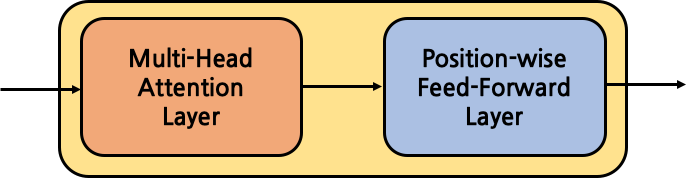
**Encoder Block은 위에서 다뤘던 Multi-Head Attention Layer와 Position-wise Feed-Forwad Layer로 구성된다. 그러나 사실은 Encoder Block을 구성하는 두 layer는 Residual Connection으로 둘러싸여 있다. Residual Connection이라는 것은 정말 단순하다. y=f(x)
를 y=f(x)+x
로 변경하는 것이다. 즉, output을 그대로 사용하지 않고, output에 input을 추가적으로 더한 값을 사용하게 된다. 이로 인해 얻을 수 있는 이점은 Back Propagation 도중 발생할 수 있는 Gradient Vanishing을 방지할 수 있다는 것이다. 개념적으로는 이 것이 전부이다. 여기에 더해 보통은 Layer Normalization과 DropOut까지 추가하지만, 본 포스팅에서는 생략한다. 간단하게 코드로 구현해보자.**

In [ ]:
class ResidualConnectionLayer(nn.Module):

    def __init__(self):
        super(ResidualConnectionLayer, self).__init__()


    def forward(self, x, sub_layer):
        out = x
        out = sub_layer(out)
        out = out + x
        return out

forward()에서 sub_layer까지 인자로 받는 구조이다.

따라서 Encoder Block의 code가 아래와 같이 변경되게 된다. residuals에 Residual Connection Layer를 2개 생성한다. forward()에서 residuals[0]은 multi_head_attention_layer를 감싸고, residuals[1]은 position_ff를 감싸게 된다.

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, self_attention, position_ff):
        super(EncoderBlock, self).__init__()
        self.self_attention = self_attention
        self.position_ff = position_ff
        self.residuals = [ResidualConnectionLayer() for _ in range(2)]


    def forward(self, src, src_mask):
        out = src
        out = self.residuals[0](out, lambda out: self.self_attention(query=out, key=out, value=out, mask=src_mask))
        out = self.residuals[1](out, self.position_ff)
        return out

esidual Connection Layer의 forward()에 sub_layer를 전달할 때에는 대개 해당 layer 자체를 넘겨주면 되지만, 필요한 경우에 따라 lambda 식의 형태로 전달할 수도 있다. 대표적으로 Multi-Head Attention Layer와 같이 forward()가 단순하게 x와 같은 인자 1개만 받는 경우가 아닐 때가 있다.

https://yngie-c.github.io/nlp/2020/07/01/nlp_transformer/
https://cpm0722.github.io/pytorch-implementation/transformer